### TF Matrix Factorization

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import collections
import pickle

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

from IPython import display

In [3]:

#SEE user_activity notebook on generating the data used and changing the params
#TODO make into callable function
user_activity = pickle.load(open('user_activity.pkl', 'rb'))

In [20]:
user_activity

,row_idx,col_idx,values
0,0,2,1
1,0,3,1
2,0,6,1
3,0,8,1
4,0,11,1
...,...,...,...
51346,199,495,-1
51347,199,496,1
51348,199,497,1
51349,199,498,1


In [ ]:
#df = user_activity.rename()

In [6]:
num_users = 200
num_lessons = 500

In [23]:
def build_sparse_tensor(sparse_idx_df, M,N):
    """
    builds a tf sparse matrix of dim number of M by N, eg. Users by Items, when considering ratings, 
    or lessons by topics when considering topics
    
    Args:
    reviews_df: a pd.DataFrame with `row_idx`, `col_idx` and `values` columns.
    Returns:
    A tf.SparseTensor representing the reviews matrix.
    """

    indices = sparse_idx_df[['row_idx', 'col_idx']].values
    values = sparse_idx_df['values'].values
    
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[M, N])

def sparse_mean_square_error(sparse_reviews, user_embeddings, lesson_embeddings):
  """
  Args:
    sparse_reviews: A SparseTensor rating matrix, of dense_shape [N, M]
    user_embeddings: A dense Tensor U of shape [N, k] where k is the embedding
      dimension, such that U_i is the embedding of user i.
    lessons_embeddings: A dense Tensor V of shape [M, k] where k is the embedding
      dimension, such that V_j is the embedding of lesson j.
  Returns:
    A scalar Tensor representing the MSE between the true reviews and the
      model's predictions.
  """
  predictions = tf.reduce_sum(
      tf.gather(user_embeddings, sparse_reviews.indices[:, 0]) *
      tf.gather(lesson_embeddings, sparse_reviews.indices[:, 1]),
      axis=1)
  loss = tf.losses.mean_squared_error(sparse_reviews.values, predictions)
  return loss

# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

def build_model(reviews, embedding_dim=3, init_stddev=1.):
  """
  Args:
    reviews: a DataFrame of the reviews
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the reviews DataFrame into train and test.
  train_reviews, test_reviews = split_dataframe(reviews)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_reviews)
  A_test = build_rating_sparse_tensor(test_reviews)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
  embeddings = {
      "user_id": U,
      "lesson_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

# Utility to split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
  """Splits a DataFrame into training and test sets.
  Args:
    df: a dataframe.
    holdout_fraction: fraction of dataframe rows to use in the test set.
  Returns:
    train: dataframe for training
    test: dataframe for testing
  """
  test = df.sample(frac=holdout_fraction, replace=False)
  train = df[~df.index.isin(test.index)]
  return train, test

def build_rating_sparse_tensor(reviews_df):
    """
    Args:
    reviews_df: a pd.DataFrame with `user_id`, `lesson_id` and `rating` columns.
    Returns:
    A tf.SparseTensor representing the reviews matrix.
    """

#     indices=np.array(list(zip(coo.row, coo.col)))
#     values = coo.data
    indices = reviews_df[['row_idx', 'col_idx']].values
    values = reviews_df['values'].values
    
    return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[num_users, num_lessons])

In [12]:
tf_sparse_ua = build_sparse_tensor(user_activity, num_users, num_lessons)

In [11]:
tf_sparse_ua

 iteration 5000: train_error=0.356153, test_error=0.521629

[{'train_error': 0.35615325, 'test_error': 0.5216292}]

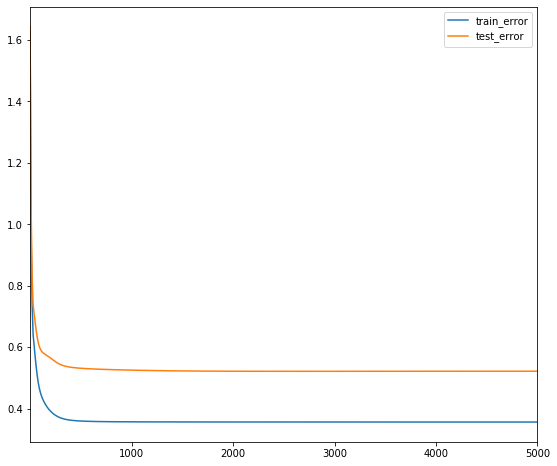

In [45]:
# Build the CF model and train it.
model = build_model(user_activity, embedding_dim=10, init_stddev=0.5)
model.train(num_iterations=5000, learning_rate=45)

In [41]:
np.sqrt(.53) / 2

0.3640054944640259

 iteration 5000: train_error=0.354405, test_error=0.538701

[{'train_error': 0.35440543, 'test_error': 0.538701}]

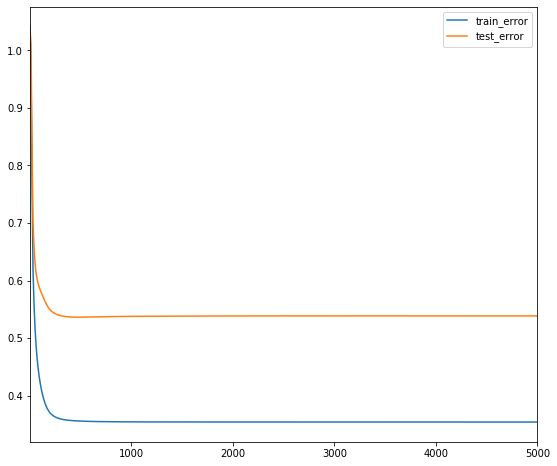

In [57]:
# Build the CF model and train it.
model = build_model(user_activity, embedding_dim=10, init_stddev=0.25)
model.train(num_iterations=5000, learning_rate=45)

In [60]:
DOT = 'dot'
COSINE = 'cosine'

def compute_scores(query_embedding, item_embeddings, measure=DOT):
  """Computes the scores of the candidates given a query.
  Args:
    query_embedding: a vector of shape [k], representing the query embedding.
    item_embeddings: a matrix of shape [N, k], such that row i is the embedding
      of item i.
    measure: a string specifying the similarity measure to be used. Can be
      either DOT or COSINE.
  Returns:
    scores: a vector of shape [N], such that scores[i] is the score of item i.
  """
  u = query_embedding
  V = item_embeddings
  if measure == COSINE:
    V = V / np.linalg.norm(V, axis=1, keepdims=True)
    u = u / np.linalg.norm(u)
  scores = u.dot(V.T)
  return scores

def user_recommendations(model, measure=DOT, exclude_rated=False, k=6):
  if USER_RATINGS:
    scores = compute_scores(
        model.embeddings["user_id"][943], model.embeddings["lesson_id"], measure)
    score_key = measure + ' score'
    df = pd.DataFrame({
        score_key: list(scores),
        'lesson_id': lessons['lesson_id'],
        'titles': lessons['title'],
        'genres': lessons['all_genres'],
    })
    if exclude_rated:
      # remove lessons that are already rated
      rated_lessons = ratings[ratings.user_id == "943"]["lesson_id"].values
      df = df[df.lesson_id.apply(lambda lesson_id: lesson_id not in rated_lessons)]
    display.display(df.sort_values([score_key], ascending=False).head(k))  

def lesson_neighbors(model, title_substring, measure=DOT, k=6):
  # Search for lesson ids that match the given substring.
  ids =  lessons[lessons['title'].str.contains(title_substring)].index.values
  titles = lessons.iloc[ids]['title'].values
  if len(titles) == 0:
    raise ValueError("Found no lessons with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching lesson. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  lesson_id = ids[0]
  scores = compute_scores(
      model.embeddings["lesson_id"][lesson_id], model.embeddings["lesson_id"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'titles': lessons['title'],
      'genres': lessons['all_genres']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

TODO: flesh out user_id and lesson_id matrices/'dbs'